In [14]:
import ppi_py as ppi
import numpy as np
import statsmodels as sm
import pandas as pd
import matplotlib.pyplot as plt

In [15]:

def simulate_ols_data(beta, ppi_corr, bias, n, N):
    """
    Simulate data for the OLS example

    Args:
        beta (ndarray): regression coefficients, shape d + 1
        ppi_corr (float): PPI correlation
        bias (float): bias to appl to all coefficients
        n (int): number of labeled samples
        N (int): number of unlabeled samples

    Returns:
        X (ndarray): covariates for labeled data , shape n x (d + 1)
        Y (ndarray): labels, shape n
        Yhat (ndarray): predictions on labeled data, shape n
        X_unlabeled (ndarray): covariates for unlabeled data, shape N x (d + 1)
        Yhat_unlabeled (ndarray): predictions on unlabeled data set shape N
    """

    d = len(beta) - 1

    X = np.random.normal(size=(n, d+1))/(d+1)**0.5
    X[:, 0] = 1

    X_unlabeled = np.random.normal(size=(N, d+1))/(d+1)**0.5
    X_unlabeled[:, 0] = 1

    max_ppi_corr = 1/(2*bias**2+1)**0.5
    max_bias = (0.5*((1/ppi_corr)**2 - 1))**0.5
    assert ppi_corr <= max_ppi_corr, f"ppi_corr must be less than {max_ppi_corr} or bias must be less than {max_bias}"

    rho = ppi_corr * (2*bias**2+1)**0.5

    Z = np.random.normal(size=n)
    Y = X @ beta + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat = X @ (beta + bias) + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat_unlabeled = X_unlabeled @ (beta + bias) + np.random.normal(size=N)

    return X, Y, Yhat, X_unlabeled, Yhat_unlabeled



In [16]:
# true intercept and slope
param = 1.
beta = np.array([param, param])

# bias 
bias = 0.3

# PPI correlation
ppi_corr = 0.9
n = 1000
N = 100000
X, Y, Yhat, X_unlabeled, Yhat_unlabeled = simulate_ols_data(beta, ppi_corr, bias, n, N)

beta


array([1., 1.])

In [17]:
ppi_est = ppi.ppi_ols_pointestimate(X=X, Y=Y, Yhat=Yhat, X_unlabeled=X_unlabeled, Yhat_unlabeled=Yhat_unlabeled)[1]
print("PPI estimate:", ppi_est)

beta_ci_ppi = ppi.ppi_ols_ci(X=X, Y=Y, Yhat=Yhat, X_unlabeled=X_unlabeled, Yhat_unlabeled=Yhat_unlabeled)
print(beta_ci_ppi)
lower_ppi = beta_ci_ppi[0][1]
upper_ppi = beta_ci_ppi[1][1]

print("PPI CI:", beta_ci_ppi[1])
print("PPI lower CI:", lower_ppi)
print("PPI upper CI:", upper_ppi)

se_ppi1 = (upper_ppi - lower_ppi) / (2 * 1.96)
se_ppi2 = (upper_ppi - ppi_est) / 1.96

print("PPI SE1:", se_ppi1)
print("PPI SE2:", se_ppi2)

silicon_est = np.linalg.solve(X_unlabeled.T @ X_unlabeled, X_unlabeled.T @ Yhat_unlabeled)
print("Silicon estimate:", silicon_est[1])

silicon_est2 = sm.regression.linear_model.OLS(Yhat_unlabeled, X_unlabeled).fit().params
print("Silicon estimate 2:", silicon_est2[1])

PPI estimate: 1.0058945333172173
(array([0.98057662, 0.97302093]), array([1.01240265, 1.03868511]))
PPI CI: [1.01240265 1.03868511]
PPI lower CI: 0.973020926516624
PPI upper CI: 1.038685112170441
PPI SE1: 0.01675106776883088
PPI SE2: 0.01672988717001208
Silicon estimate: 1.2999160692196783
Silicon estimate 2: 1.2999160692196816


In [18]:
# true intercept and slope
param = 1.
beta = np.array([param, param])

# bias 
bias = 0.3

# PPI correlation
ppi_corr = 0.9

# sample size human subjects
ns = [1000]

# multiples of human subjects sample size
ks = list([0.25, 0.5, 0.75]) + list(np.arange(1, 10.5, 0.5))

# sample size silicon subjects 
Ns = [int(n * k) for n in ns for k in ks]

# number of repetitions for combinations of n and N
reps = 30

# initialize list to collect results
results = []

# initialize a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(seed=20241026)

# loop over repetitions
for r in range(reps):

  # keep track of progress
  if (r+1) % 10 == 0 or r == 0:
    print(f"Repetition {r+1} out of {reps}")

  # loop over the combinations of n and N
  for n in ns:      

    for N in Ns:
      # simulate data
      X, Y, Yhat, X_unlabeled, Yhat_unlabeled = simulate_ols_data(beta, ppi_corr, bias, n, N)

      # get silicon sampling estimates
      mod_sil = sm.regression.linear_model.OLS(Yhat_unlabeled, X_unlabeled).fit()
      beta_sil = mod_sil.params[1]
      se_sil = mod_sil.bse[1]

      beta_ci_sil = mod_sil.conf_int(alpha = 0.05)[1]
      lower_sil = beta_ci_sil[0]
      upper_sil = beta_ci_sil[1]

      # get coefficient estimate from mixed-subjects PPI
      mod_ppi = ppi.ppi_ols_pointestimate(
        X, 
        Y, 
        Yhat, 
        X_unlabeled, 
        Yhat_unlabeled)
      beta_ppi = mod_ppi[1]

      # compute PPI standard error from CIs
      beta_ci_ppi = ppi.ppi_ols_ci(X=X, Y=Y, Yhat=Yhat, X_unlabeled=X_unlabeled, Yhat_unlabeled=Yhat_unlabeled)
      lower_ppi = beta_ci_ppi[0][1]
      upper_ppi = beta_ci_ppi[1][1]
      se_ppi = (upper_ppi - lower_ppi) / (2 * 1.96)

      # report whether the true value is within the confidence interval
      ci_ppi_covers_param = int(lower_ppi <= param <= upper_ppi)
      ci_sil_covers_param = int(lower_sil <= param <= upper_sil)

      # append the results to the list as a dictionary
      results.append({
          'beta_ppi': beta_ppi,
          'se_ppi': se_ppi,
          'lower_ppi': lower_ppi,
          'upper_ppi': upper_ppi,
          'ci_ppi_covers': ci_ppi_covers_param,
          'beta_sil': beta_sil,
          'se_sil': se_sil,
          'lower_sil': lower_sil,
          'upper_sil': upper_sil,
          'ci_sil_covers': ci_sil_covers_param,
          'n': n,
          'N': N,
          'rep': r+1
      })
  
# convert list of dictionaries to a pandas DataFrame
result_df = pd.DataFrame(results).sort_values(by=['rep', 'n', 'N'], ascending=True)

# Display the first few rows of the DataFrame to verify
print(result_df.head(10))

# Group by 'n' and 'N', then calculate mean across repetitions
stats = ['beta_ppi','se_ppi','lower_ppi','upper_ppi','ci_ppi_covers',
         'beta_sil','se_sil','lower_sil','upper_sil','ci_sil_covers']
df = result_df.groupby(['n', 'N'])[stats].mean().reset_index()

# Calculate bias columns
df['bias_ppi'] = df['beta_ppi'] - 1
df['bias_sil'] = df['beta_sil'] - 1

# Save averaged simulation results to compressed csv file
df.to_csv("../Data/simulation_study.csv.gz", compression="gzip", index=False)

Repetition 1 out of 30
Repetition 10 out of 30
Repetition 20 out of 30
Repetition 30 out of 30
   beta_ppi    se_ppi  lower_ppi  upper_ppi  ci_ppi_covers  beta_sil  \
0  1.047852  0.034277   0.979401   1.113768              1  1.462714   
1  1.049562  0.032314   0.986186   1.112856              1  1.362140   
2  0.977133  0.032757   0.912875   1.041284              1  1.276997   
3  1.037450  0.028333   0.981916   1.092983              1  1.352615   
4  0.958001  0.026535   0.905983   1.010001              1  1.254101   
5  1.022732  0.024941   0.973794   1.071562              1  1.298233   
6  1.035324  0.025241   0.985475   1.084420              1  1.369313   
7  0.996294  0.022443   0.952349   1.040327              1  1.278775   
8  0.964343  0.023615   0.918053   1.010626              1  1.260463   
9  0.996232  0.022666   0.951553   1.040402              1  1.319647   

     se_sil  lower_sil  upper_sil  ci_sil_covers     n     N  rep  
0  0.089950   1.285551   1.639878           


Averaged Results by n and N:
      n     N  beta_ppi    se_ppi  lower_ppi  upper_ppi  ci_ppi_covers  \
0  1000   250  1.012850  0.034715   0.944529   1.080613       0.966667   
1  1000   500  1.002290  0.032019   0.939327   1.064842       0.966667   
2  1000   750  0.993190  0.030240   0.933733   1.052274       0.966667   
3  1000  1000  0.999446  0.028946   0.942565   1.056034       0.933333   
4  1000  1500  1.001863  0.026906   0.949041   1.054511       1.000000   

   beta_sil    se_sil  lower_sil  upper_sil  ci_sil_covers  bias_ppi  bias_sil  
0  1.328494  0.089118   1.152970   1.504018       0.033333  0.012850  0.328494  
1  1.312819  0.062873   1.189290   1.436348       0.000000  0.002290  0.312819  
2  1.286905  0.052094   1.184636   1.389173       0.000000 -0.006810  0.286905  
3  1.305009  0.044866   1.216967   1.393051       0.000000 -0.000554  0.305009  
4  1.302218  0.036589   1.230447   1.373988       0.000000  0.001863  0.302218  


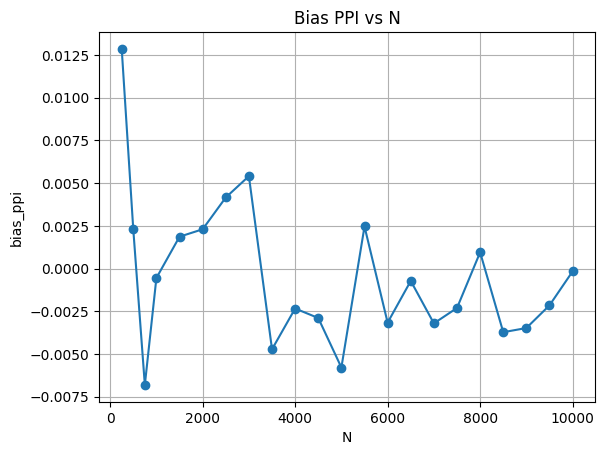

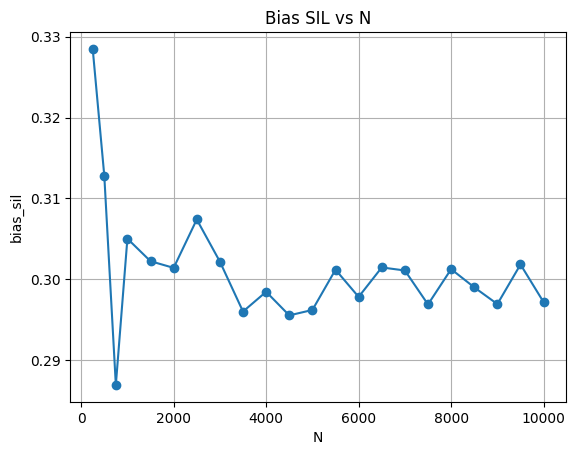

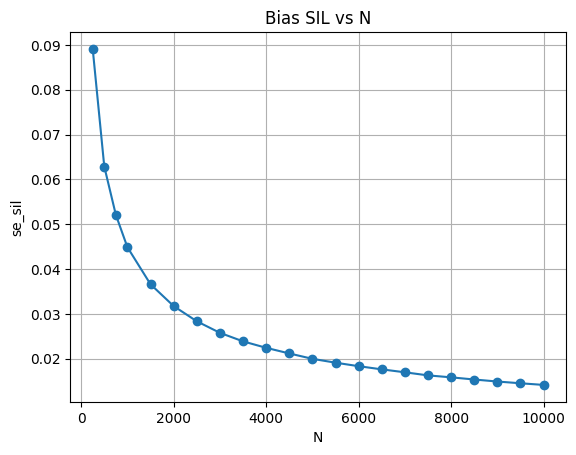

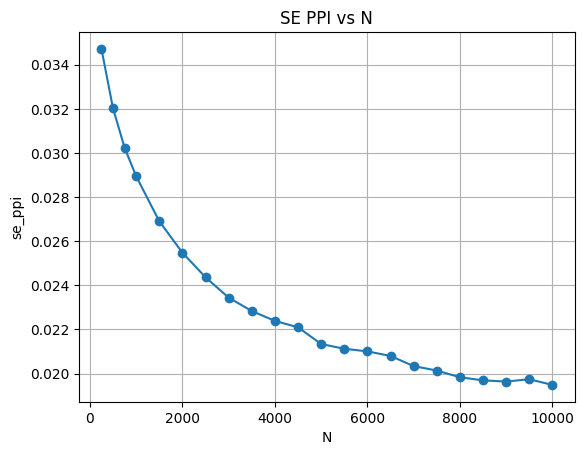

In [19]:


# display the first few rows of the averaged DataFrame to verify
print("\nAveraged Results by n and N:")
print(df.head())

# Plot bias_ppi vs N
plt.figure()
plt.plot(df['N'], df['bias_ppi'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_ppi')
plt.title('Bias PPI vs N')
plt.grid(True)
plt.show()

# Plot bias_sil vs N
plt.figure()
plt.plot(df['N'], df['bias_sil'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_sil')
plt.title('Bias SIL vs N')
plt.grid(True)
plt.show()

# Plot se_sil vs N
plt.figure()
plt.plot(df['N'], df['se_sil'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('se_sil')
plt.title('Bias SIL vs N')
plt.grid(True)
plt.show()

# Plot se_ppi vs N
plt.figure()
plt.plot(df['N'], df['se_ppi'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('se_ppi')
plt.title('SE PPI vs N')
plt.grid(True)
plt.show()